In [ ]:
# Define virtual lab and project. This allows members of the project to access project resources
OBI_PROJECT_ID: str = 'e64062c7-a16c-482c-93f5-e0c55a14683c'
OBI_VLAB_ID: str = '2f20b347-1130-490a-8618-c4f34e08eb01'

<center><font size = "8">Analysis of electro-physiological traces<center>

<font size=4><font color=blue> In this notebook you will learn:
<ul style="color: blue; font-size: 18px;">
    <li> to ifferenciate two different cell types depending on their firing pattern with subthres-hold and supra-threshold stimulations</li>
    <li> to analyse real single cell traces with different stimulations</li>
    <li> to analyse synaptic traces and differenciate between action potentials and post-synaptic potentials</li>
</ul>

<p style="color: red; font-size: 16px;"><b>IMPORTANT:</b> this notebook is using <b>Python</b> code to help you load, visualize and analyze the morphologies.</p>
<ul style="color: red; font-size: 16px;">
  <li><b>YOU DON'T NEED TO KNOW HOW TO CODE!</b> (you will learn to code in future courses)</li>
  <li>YOU WOULD ONLY RUN THE CELLS. To run a cell: </li>
    <ul style="color: red; font-size: 16px;">
        <li>Click once on one of the cells, you will notice that it is sellected because it is highlighted in blue.</li>
        <li>Press "Command+enter" or click on the Run (triangle) button at the top of the page.</li>
        <li>Consider that cells <b>must be run by order</b> </li>
    </ul>
</ul>

In [ ]:
import requests, os

extra_files_root = "https://raw.githubusercontent.com/NataliBZ/uc3m_notebooks/main/"

extra_files_names = [
    "Cellular/04_Analysis_of_traces/connection_test.h5",
    "Cellular/04_Analysis_of_traces/instantiate_neuron.py",
    "Cellular/04_Analysis_of_traces/Relevant_functions.py",
    "Cellular/04_Analysis_of_traces/stimuli.py",
    "Cellular/04_Analysis_of_traces/Sub_threshold_cell2.csv",
    "Cellular/04_Analysis_of_traces/Sub_threshold_cell2.csv",
    "Cellular/04_Analysis_of_traces/output1.csv",
    "Cellular/04_Analysis_of_traces/output1.csv",
    "Cellular/04_Analysis_of_traces/Synapses.png",
    "Cellular/04_Analysis_of_traces/data/" ############ AÑADIR UNO A UNO!!!
]
for fn in extra_files_names:
    req = requests.get(extra_files_root + fn)
    if req.status_code == 200:
        with open(os.path.split(fn)[1], "wb") as fid:
            fid.write(req.content)
    else:
        print("Error obtaining auxiliary file!")

## 1. Studying single cell passive and active properties: sub-threshold and supra-threshold stimulations

In [1]:
# Load usefull packages
%matplotlib inline

from neuron import h
import hoc
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import view
import pandas as pd
import h5py
import csv
import glob

import efel
from json2html import *
import IPython
import ipywidgets as widgets
from IPython.display import display, clear_output

import instantiate_neuron as IN
import stimuli
import Relevant_functions as rf

--No graphics will be displayed.


## Sub-threshold stimulation

<ul style="font-size: 18px;">
    <li>A current pulse that does not reach the threshold needed to trigger an action potential.</li>
    <li>The cell responds only with a graded change in membrane potential (a depolarization or hyperpolarization), but no spike is fired.</li>
    <li>Useful to study passive properties of the membrane (e.g., input resistance, capacitance, time constant).</li>
</ul>


5771 lines read

data/Cell_01.asc problems


Main branch starting at line 31 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

15199 lines read


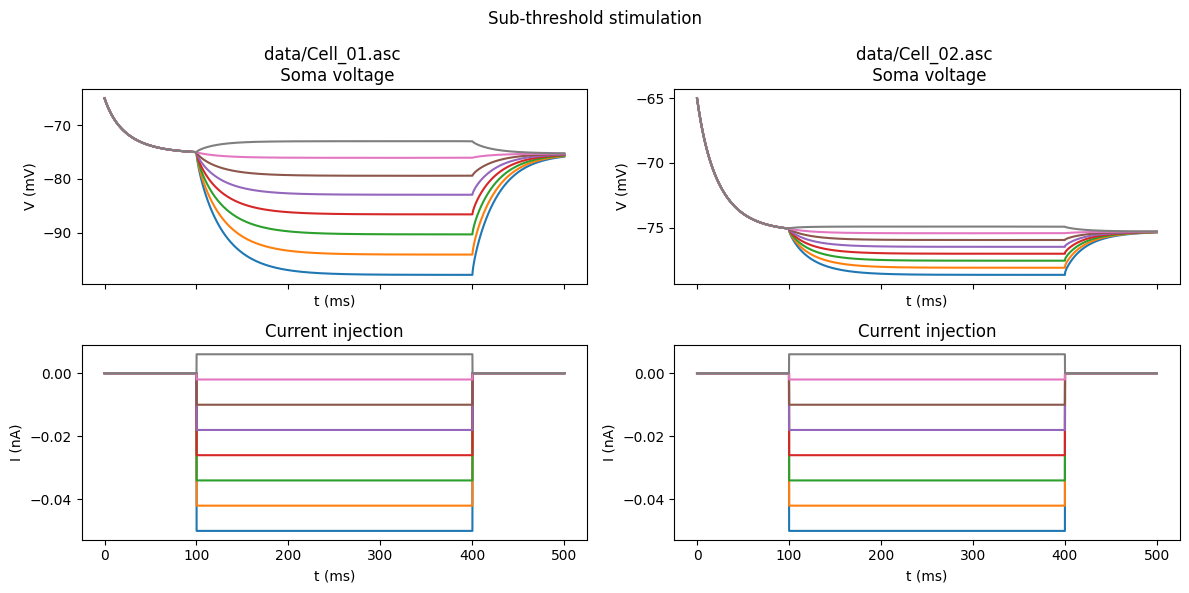

In [2]:
stim_ampl_1 = np.arange(- 0.05, 0.01, 0.008)

filename1 = 'data/Cell_01.asc'
filename2 = 'data/Cell_02.asc'

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Left column: neuron 1
stimuli.SquarePulses_stim(stim_ampl_1, filename1, 'Sub_threshold_cell1.csv', axs=axs[:,0])

# Right column: neuron 2
stimuli.SquarePulses_stim(stim_ampl_1, filename2, 'Sub_threshold_cell2.csv', axs=axs[:,1])

fig.suptitle('Sub-threshold stimulation')
plt.tight_layout()
plt.show()


# Supra-threshold stimulation

<ul style="font-size: 18px;">
    <li>A current pulse that exceeds the threshold for firing.</li>
    <li>The depolarization activates voltage-gated channels, and the cell generates an action potential (all-or-none spike).</li>
    <li>Useful to study active properties of the neuron (e.g., action potential shape, firing patterns, excitability).</li>
</ul>


5771 lines read

data/Cell_01.asc problems


Main branch starting at line 31 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

15199 lines read


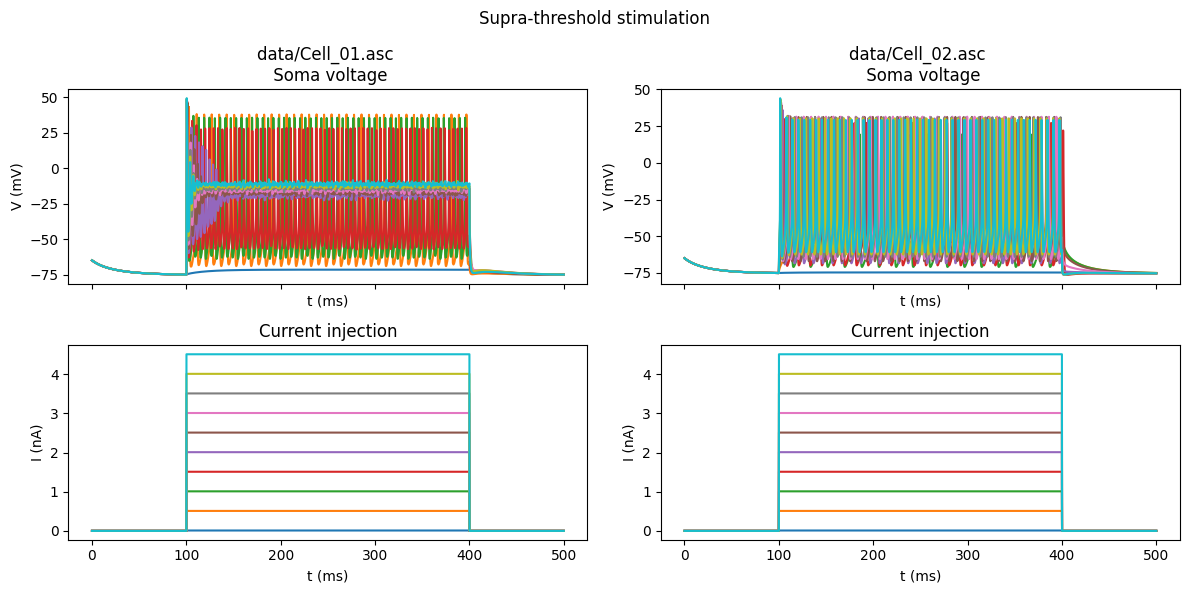

In [3]:
stim_ampl_2 = np.arange(0.01, 5.0, 0.5)

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Left column: neuron 1
stimuli.SquarePulses_stim(stim_ampl_2, filename1, 'Sub_threshold_cell1.csv', axs=axs[:,0])

# Right column: neuron 2
stimuli.SquarePulses_stim(stim_ampl_2, filename2, 'Sub_threshold_cell2.csv', axs=axs[:,1])

fig.suptitle('Supra-threshold stimulation')
plt.tight_layout()
plt.show()

<font size=6><font color=blue> Question 1:

<font size=4><font color=blue>Explain how do you think subthreshold and suprathreshold stimulations are useful and what type of neuronal properties you can study with each of them.

<font size=4><font color=blue>Compare the plots above of Cell_01 and Cell_02. Explain the differences observed. What can you tell about their passive and active cell proterties?

## 2. Analysing real single cell recordings from patch-clamp experiments

<ul style="font-size: 18px;">
These type of experiments, similarly to the ones shown above, are done by stimulating and recording simultaneously on the cell soma.
</ul>

### Traces description

<ul style="font-size: 18px;">
    <li>The files inside the "data" folder, are named with: stimuli type (e.g. "APWaveform", "FirePattern", "IV").</li> 
    <li>Sweep (repetition) number: (e.g. "APWaveform_46-51"), of increasing/decreasing amplitudes.</li> 
    <li>Note that we have pairs of recordings with the same trace number (e.g. "exp_APWaveform_ch7_51.dat" and "exp_APWaveform_ch6_51.dat"). One of them contains the current stimulus (in this case "*ch7*") and the other the voltage response (in this case "*ch6*").</li> 
</ul>

### For the analyses:

<p style="font-size: 18px;">
We will use a library called <a href="https://efel.readthedocs.io/en/latest/eFeatures.html#burst-isi-indices" target="_blank">eFEL</a>. Click on the link if you rae curious about what parameters you can extract from this type of traces.
</p>

In [4]:
rf.choose_protocol()

### Can you tell if it is a suprathreshold or subthreshold stimulation?

#### Choose the correct answer and perform some analysis on the response file.
#### If you see errors, that means your answer was wrong. 

In [5]:
rf.choose_answer()

## 3. Analysing post-synaptic potentials

<ul style="font-size: 18px;">
In this type of experiments what we want to see is how one neuron respond to the activity of the neuron that is connected to it. 

Then what we see here is the stimulation in the pre-synaptic neuron and the response of the post-synaptic neuron.
</ul>

### Action Potential vs Post-synaptic Potential 

#### Action Potential (AP)
<ul style="font-size: 18px;">   
    <li>What it is: A rapid, all-or-none electrical signal that travels along the axon of a neuron.</li>
    <li>Where it happens: Typically starts at the axon hillock and propagates along the axon.</li>
    <li>How it’s generated: Caused by the opening of voltage-gated sodium (Na⁺) and potassium (K⁺) channels. Once the threshold is reached, the full spike always occurs (all-or-none).</li>
    <li>Amplitude: Large (~100 mV, from –70 mV up to +30 mV).</li>
    <li>Function: Used to transmit information over long distances in the nervous system.</li>
</ul>

#### Postsynaptic Potential (PSP)
<ul style="font-size: 18px;">  
    <li>What it is: A small, graded change in membrane potential in the postsynaptic neuron after neurotransmitter binding.</li>
    <li>Where it happens: On the dendrites or soma of the postsynaptic neuron.</li>
    <li>How it’s generated: Caused by the opening of ligand-gated ion channels (e.g., glutamate receptors, GABA receptors) when neurotransmitters bind.</li>
    <li>Amplitude: Small (a few mV, usually 0.2–20 mV), and proportional to the amount of neurotransmitter released.</li>
    <li>Function: They integrate (summation of many PSPs) and determine whether the postsynaptic neuron reaches threshold to fire an action potential.</li>
    <li>Excitatory PSP (EPSP): depolarizes, makes firing more likely.</li>
    <li>Inhibitory PSP (IPSP): hyperpolarizes, makes firing less likely.</li>
</ul>

# EXPLICAR MEJOR Y MAS INTERACTIVO

Text(0.5, 0, 'time (ms)')

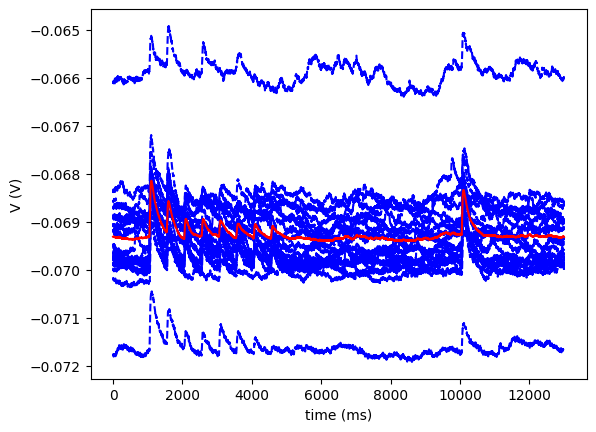

In [6]:
# Open and print keys to check how many sweeps (repetitions) of the experiment there are in the file
data = h5py.File("connection_test.h5", "r")

# Create a data array and compute the mean trace by computing the mean of all sweeps
traces = []
for key in data.keys():
    traces.append(data.get(key))

traces = np.array(traces)

mean_trace = np.mean(traces, axis=0)

# plot the sweeps and the mean voltage trace
plt.figure()

for trace in traces:
    plt.plot(trace, "b--")

plt.plot(mean_trace, "r")
plt.ylabel('V (V)')
plt.xlabel('time (ms)')

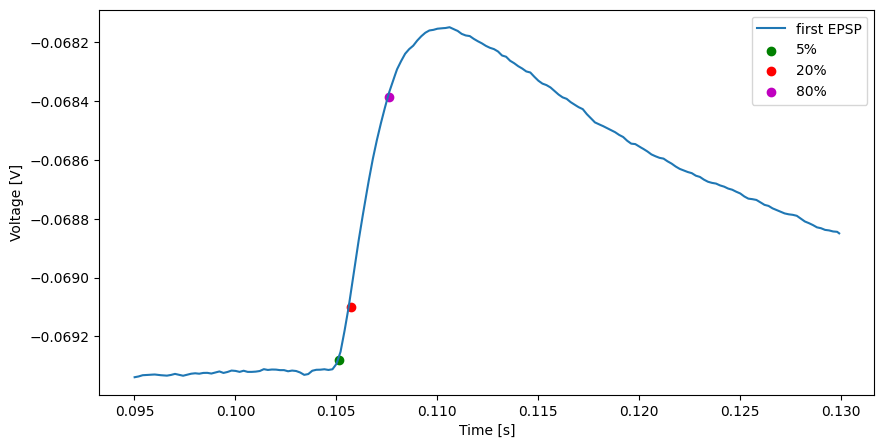

Amplitude =  0.7139286824635049 mV
Tau_rise =  0.0019001461650896279 s
latency =  0.005100392337872142 s


In [7]:
time = np.linspace(0, 1.3, 13000)
stimulation_indices = np.array([1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000])

stimulation_time = time[stimulation_indices[0]]

psp_trace, psp_time = rf.extract_PSP_window(mean_trace, time, stimulation_indices[0])

psp_percent, psp_times, amplitude, tau_rise, latency = rf.extract_EPSP_features(
    psp_trace, psp_time, stimulation_time
)
plt.figure(figsize=(10, 5))
plt.plot(psp_time, psp_trace, label="first EPSP")
plt.scatter(psp_times["five"], psp_percent["five"], c="g", label="5%")
plt.scatter(psp_times["twenty"], psp_percent["twenty"], c="r", label="20%")
plt.scatter(psp_times["eighty"], psp_percent["eighty"], c="m", label="80%")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

plt.legend()
plt.show()

print("Amplitude = ", np.abs(amplitude*1000.0), "mV")
print("Tau_rise = ", tau_rise, "s")
print("latency = ", latency, "s")

#### This protocol of STDP (short term dependent plasticity) has been used to classified synapses depending on the dynamics and this data can also be analysed

<center><img src="Synapses.png" width="700"><center>

### One very common analysis: FAILURE RATE

<font size='3'>The failure rate is the fraction of trials from which no PSP is generated above certain threshold. You can find a way of computing the failure rate in [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/).

In [8]:
files = [
    "data/connection_c1.h5",
    "data/connection_c2.h5",
    "data/connection_c4.h5",
]

In [9]:
conn1, conn2, conn3 = rf.compute_failure_rate(files)

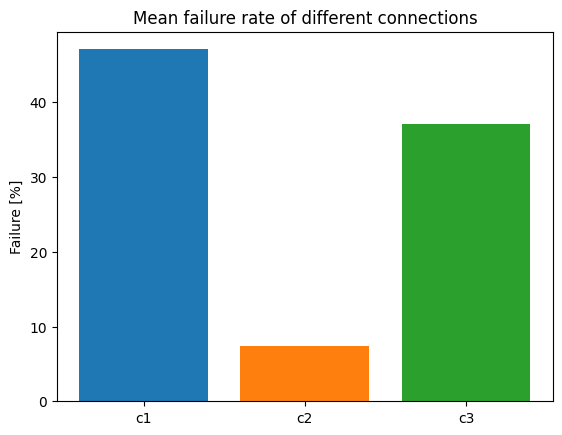

In [10]:
data_name = ["c1", "c2", "c3"]
fails = [conn1[0], conn2[0], conn3[0]]
total = conn1[1]
plt.bar(data_name[0], fails[0] / total * 100)
plt.bar(data_name[1], fails[1] / total * 100)
plt.bar(data_name[2], fails[2] / total * 100)

plt.title("Mean failure rate of different connections")
plt.ylabel("Failure [%]");

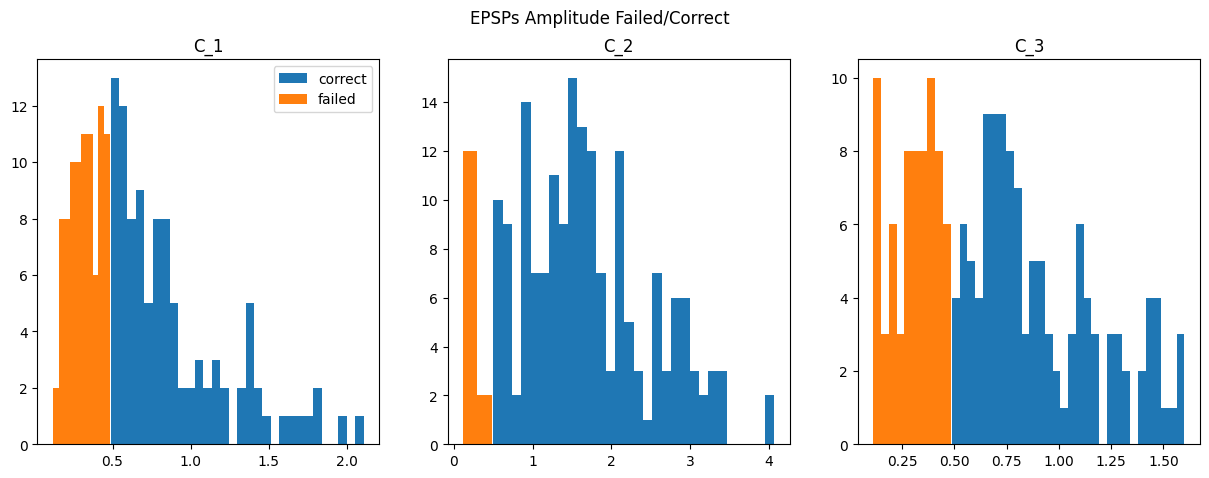

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(conn1[3], bins=30, label="correct")
ax[0].hist(conn1[2], label="failed")

ax[1].hist(conn2[3], bins=30, label="correct")
ax[1].hist(conn2[2], bins=2, label="failed")

ax[2].hist(conn3[3], bins=30, label="correct")
ax[2].hist(conn3[2], label="failed")

fig.suptitle("EPSPs Amplitude Failed/Correct")
ax[0].set_title("C_1")
ax[1].set_title("C_2")
ax[2].set_title("C_3")
ax[0].legend();

<font size=6><font color=blue> Question 2:

<font size=4><font color=blue>Why do you think that analysing the amplitud of an EPSP is important and we don't do the same for action potentials? What is this measurement telling you about the neuronal connection?

<font size=6><font color=blue> Question 3:

<font size=4><font color=blue>Hypothesize what are the functional differences between the three connections. What does it mean that connection 2 has such a low firing rate?